## SNLP Summer 2020 Assignment 9
#### Expectation Maximization Algorithm for Word Sense Disambiguation



Name: Awantee Deshpande
<br/>Id: 2581348
<br/>Email: s8awdesh@stud.uni-saarland.de
<br/>
<br/>Name: Lakshmi Rajendra Bashyam
<br/>Id: 2581455
<br/>Email: s8laraje@stud.uni-saarland.de

In [ ]:
import nltk
nltk.download('senseval')
from nltk.corpus import senseval
from collections import Counter
import time
import math

import numpy as np
import matplotlib.pyplot as plt

[nltk_data] Downloading package senseval to /root/nltk_data...
[nltk_data]   Unzipping corpora/senseval.zip.


In [ ]:
hard_f, interest_f, line_f, serve_f = senseval.fileids()

Class EM :

EM_step: Does the expectation step
M_step: Does the maximisation step

In [ ]:
class sample(object):
    def __init__(self, inst):
        self.label=inst.senses[0]
        p = inst.position
        context = [tuple[0]  for tuple in inst.context[p-5:p] if len(tuple)>1] 
        #checking if list element is actually a tuple, phrasal elements are not
        context+= [tuple[0] for tuple in inst.context[p+1:p+6] if len(tuple)>1]
        self.context=context

    def context_to_index(self, word_to_id):
        self.context=context_to_id(self.context, word_to_id)
        
class EM(object):
    def __init__(self, V, K):
        """
        Randomly initializes the priors and the class conditional probabilitied
        :param samples: list of sample objects
        :set:    self.probs: vocabulary_size * num_senses sized matrix, i.e. each column is a class conditional probability distribution
                 self.priors: vector of prior probabilities
                
        """
        self.V = V
        self.K = K
        
        #priors = P(Sk)
        priors=np.random.rand(K)
        #normalize
        priors=np.divide(priors, np.sum(priors))
        
        #probs = P(vj|sk)
        probs=np.random.rand(V, K)
        #normalize
        probs=np.divide(probs, np.sum(probs, axis=0))

        self.priors=priors
        self.probs=probs

    def E_step(self,samples):
        """"
        TO DO
        E-step
        :param samples: list of sample objects
        :return:  H is a matrix of size sample_size * num_senses
                H[i,k] = h_{i,k} from the slides
        """
        probs = self.probs
        priors = self.priors
        H = np.zeros([len(samples),len(priors)])
        
        for i in range(len(samples)):
            context_index=samples[i].context #ci
            words_given_sense=probs[context_index, :] #P(vj|sk)
            context_given_sense=np.prod(words_given_sense, axis=0) #P(ci|sk)
            
            #multiply by priors
            context_probs=np.multiply(context_given_sense, priors)
            H[i,:] = np.divide(context_probs, np.sum(context_probs))
        
        return H

    def M_step(self, H, C):
        """
        TO DO
        M step 
        Update self.priors and self.probs
        """
        priors = self.priors
        probs = self.probs
        
        np.matmul(C.transpose(), H, out=probs)
        probs = np.divide(probs, np.sum(probs, axis=0))
        
        z_ = H.sum()
        priors = np.sum(H, axis=0)
        priors = np.divide(priors, z_)
        
        self.priors = priors
        self.probs = probs

    def run(self, samples, C):
        """
        Iterates E step and M step until convergence
        param: samples: list of sample objects
               C: num_samples x vocablary_size matrix where each row is contains the word counts in a given context
        return: labels: final clustering
    
        """
        ll_graph = []
        
        MAX_ITER = 0
        #initial log likelihood
        ll = log_likelihood(samples, self.probs, self.priors)
        
        while True:
            #E-step        
            H = self.E_step(samples)
            #M-step
            self.M_step(H,C)          

            old_ll = ll
            ll = log_likelihood(samples, self.probs, self.priors)
            ll_graph.append(ll)
            print(f"Log likelihood = {ll}")
            
            if abs(ll - old_ll) < 1e-5:
                break
            
            MAX_ITER += 1
            
        labels = np.argmax(H, axis=1)
        print(f"Number of iterations = {MAX_ITER}")
        return labels, ll_graph

Other helper functions

In [ ]:
def create_vocab(samples):
    words = set([w for s in samples for w in s.context])
    word_to_id = dict(zip(words, range(len(words))))
    senses = set([s.label for s in samples])
    return word_to_id, len(word_to_id), len(senses)


def context_to_id(context, word_to_id):
    return np.array([word_to_id[w] for w in context])


def log_likelihood(samples, probs, priors):
    """
    :param samples: list of sample objects
    :param probs: vocab_size x num_senses sized matrix containing class conditional distributions
    :param priors: num_senses long vector with prior probs
    :return: log likelihood of corpus
    """
    
    ll = 0
    for sample in samples:
        context_index = sample.context
        words_given_sense = probs[context_index, :]
        context_given_sense = np.prod(words_given_sense, axis=0)
        #multiply by priors
        context_probs = np.multiply(context_given_sense, priors)
        marginal = sum(context_probs)
        ll += np.log(marginal)
        
    return ll

def counts_matrix(samples, V):
    """
    :param samples: list of sample objects
    :param V: length of vocabulary
    :return: num_samples x vocablary_size matrix where each row is contains the word counts in a given context
    """
    C = np.zeros([len(samples), V])
    it = 0
    total = 0
    
    for sample in samples:
        context_index = sample.context
        freq_dict = Counter(context_index) 
        tuples = [tuple([x,y]) for x, y in freq_dict.items()]
        ids, counts = zip(*tuples)

        C[it, ids] = counts
        it += 1

    return C

Main function

In [ ]:
t0 = time.time()
instances = senseval.instances(hard_f)

# all training samples as a list
samples = [sample(inst) for inst in instances]

#V is size of Vocab, K is number of clusters
word_to_id, V, K = create_vocab(samples)

#convert contexts to indices so they can be used for indexing
for smpl in samples:
    smpl.context_to_index(word_to_id)

Initialise EM object and run on the senseval "hard" samples

In [ ]:
# initialize vj|s, priors
E_M = EM(V, K)  

# C is a sample_size * vocab_size matrix
C = counts_matrix(samples, V)

#run the model
labels, graph = E_M.run(samples,C)

Log likelihood = -205915.77165270355
Log likelihood = -204740.51491732986
Log likelihood = -204201.70211572605
Log likelihood = -203931.36900164175
Log likelihood = -203794.90872612534
Log likelihood = -203707.43851125106
Log likelihood = -203656.72406089984
Log likelihood = -203619.27640316306
Log likelihood = -203590.14765192024
Log likelihood = -203570.61998674803
Log likelihood = -203557.37129381456
Log likelihood = -203546.93096488854
Log likelihood = -203537.66176315185
Log likelihood = -203528.84950782693
Log likelihood = -203519.88068404232
Log likelihood = -203509.9205512534
Log likelihood = -203502.17771681427
Log likelihood = -203494.0962738753
Log likelihood = -203485.99255244355
Log likelihood = -203480.66951504897
Log likelihood = -203478.0275090736
Log likelihood = -203476.7290649542
Log likelihood = -203475.58151922232
Log likelihood = -203473.88332740968
Log likelihood = -203470.79074068373
Log likelihood = -203467.3090726516
Log likelihood = -203463.57083043444
Log li

Log likelihood = -203377.63623493575
Log likelihood = -203377.62954075265
Log likelihood = -203377.61991410854
Log likelihood = -203377.6057036216
Log likelihood = -203377.58417829406
Log likelihood = -203377.55087834355
Log likelihood = -203377.49918420095
Log likelihood = -203377.42221865687
Log likelihood = -203377.32147722968
Log likelihood = -203377.21771348646
Log likelihood = -203377.13684364935
Log likelihood = -203377.08082526925
Log likelihood = -203377.03586807247
Log likelihood = -203376.99128017033
Log likelihood = -203376.94108258453
Log likelihood = -203376.88156877938
Log likelihood = -203376.81129674753
Log likelihood = -203376.7325796382
Log likelihood = -203376.65176038668
Log likelihood = -203376.57622748913
Log likelihood = -203376.51066419674
Log likelihood = -203376.45616764494
Log likelihood = -203376.41112105318
Log likelihood = -203376.3715837037
Log likelihood = -203376.33102646624
Log likelihood = -203376.279173021
Log likelihood = -203376.19957875588
Log li

### Analysis

1) 
Some kinds of data result from drawing from multiple distributions. If the parameters of those distributions are known, it is simple to determine which distribution a data point comes from. But if those parameters are not known, expectation maximization can be used to determine the likelihood of a data point belonging to a particular distribution using some latent variable.
EM is particularly used to fit a model in an unsupervised setting. It estimates the values of the latent variables, optimises the model, and then repeats these steps till the log likelihood converges.
<br/>One well known use-case of Expectation Maximization is in the Baum-Welch algorithm for Hidden Markov Models. It is used to calculate the state transition probabilities and the emission probabilities to maximise the given data observation.

2)
The code for the expectation and maximisations steps is in the functions E_step and M_step respectively in this notebook.
The change in log likelihood is modeled below as follows:
(It can be observed that the log likelihood increases over the iterations until it converges)

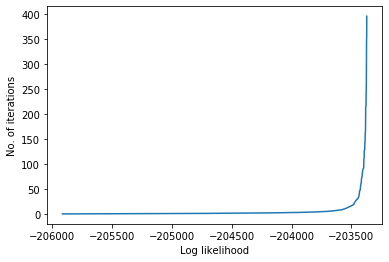

In [ ]:
plt.plot(graph, list(range(1, len(graph)+1)))
plt.xlabel("Log likelihood")
plt.ylabel("No. of iterations")
plt.show()

3) 
The outputted ordered frequency of labels within each cluster is displayed by the code below:
We can see that all the senses are assigned to different clusters with varying frequencies by the EM algorithm.

In the code snippet below, we try to estimate the true clustering of the samples by using the labels known to us (these cannot be used for unsupervised training), and we should expect a clear majority of one kind of sense in one cluster. But this does not happen. The sense 'HARD1' has a large set of examples as compared to 'HARD2' and 'HARD3'. Because of the random initialisation and imbalanced cluster sizes, EM does not give an exact split according to the senses.

In [ ]:
clusters = [[] for i in range(K)]
for i in range(len(samples)):
    cl_i = labels[i]
    clusters[cl_i].append(samples[i])

i = 0
for cluster in clusters:
    sense_counts = Counter([sample.label for sample in cluster])
    ordered = sense_counts.most_common()
    print("ordered list of senses within cluster {0}: ".format(i),ordered)
    i += 1

t1 = time.time()
total_time = t1-t0
print("Time: ", total_time)

ordered list of senses within cluster 0:  [('HARD1', 1357), ('HARD3', 174), ('HARD2', 120)]
ordered list of senses within cluster 1:  [('HARD1', 449), ('HARD2', 210), ('HARD3', 67)]
ordered list of senses within cluster 2:  [('HARD1', 1649), ('HARD2', 172), ('HARD3', 135)]
Time:  138.99180507659912


In [ ]:
clusters2 = [[] for i in range(K)]
labels2 = {'HARD1':0, 'HARD2':1, 'HARD3':2}

for i in range(len(samples)):
    cl_i = labels2[samples[i].label]
    clusters2[cl_i].append(samples[i])

i = 0
for cluster in clusters2:
    sense_counts = Counter([sample.label for sample in cluster])
    ordered = sense_counts.most_common()
    print("ordered list of senses within cluster {0}: ".format(i),ordered)
    i += 1

ordered list of senses within cluster 0:  [('HARD1', 3455)]
ordered list of senses within cluster 1:  [('HARD2', 502)]
ordered list of senses within cluster 2:  [('HARD3', 376)]


4)
EM does not find the global optimum. Similar to gradient descent, it only converges to a point where the log likelihood ~ 0 w.r.t the parameters. This kind of search is local and and largely dependent on the first initialisations of the parameters. 

As a result of this, EM can also be slow to converge based on how it is initialised.

#### ----------------------------------------------------------------------------------xxxxxx-----------------------------------------------------------------------------------------------------